In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
df =pd.read_csv('real_estate_data.csv', sep='\t')

#Предобработка данных
Ниже будет представлен блок, отведённый под анализ столбцов, в которых есть пропуски.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

## Определить, в каких столбцах есть пропуски
По результатм анализа исходного датасета наблюдаем, что среди 22-х столбцов пропуски имеются в 14-ти столбцах:


*   ceiling_height
*   floors_total
*   living_area
*   is_apartment
*   kitchen_area
*   balcony
*   locality_name
*   airports_nearest
*   cityCenters_nearest
*   parks_around3000
*   parks_nearest
*   ponds_around3000
*   ponds_nearest
*   days_exposition




## Заполнение пропусков

Пропуски в данных о высоте потолков целесообразно заменить на среднее значение, так как заявлять ноль как высоту потолков - нелогично. Среднее значение будем высчитывать среди квартир с тем же числом комнат, что и в пропусках, дабы приблизить схожесть результатов.

In [ ]:
mean_hight = df.groupby(['rooms'])['ceiling_height'].mean()
for i in mean_hight.index:
  df.loc[(df['ceiling_height'].isna()) & (df['rooms'] == i), 'ceiling_height'] = df.loc[(df['ceiling_height'].isna()) & (df['rooms'] == i), 'ceiling_height'].fillna(round(mean_hight[i],2))

Проведём обработку общего числа этажей в квартирах.

In [ ]:
ceiling_medians = df.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['median', 'count'])
ceiling_medians.columns = ['median', 'count']
ceiling_medians.head()

,median,count
floors_total,,
1.0,2.76,25
2.0,2.76,383
3.0,2.76,668
4.0,2.77,1200
5.0,2.72,5787


In [ ]:
for floor in ceiling_medians.index:
    df.loc[(df['floors_total'].isna()) | 
             ((df['floors_total'] == floor) & (ceiling_medians.loc[floor, 'count'] == 0)), 
             'ceiling_height'] = df['ceiling_height'].describe()[5]

In [ ]:
for floor in ceiling_medians.index:
    df.loc[(df['ceiling_height'].isna()) & 
             (df['floors_total'] == floor), 
             'ceiling_height'] = ceiling_medians.loc[floor, 'median']

In [ ]:
df.dropna(subset=['floors_total'], inplace=True)

Проанализируем зависимость общей площади квартиры от жилой площади

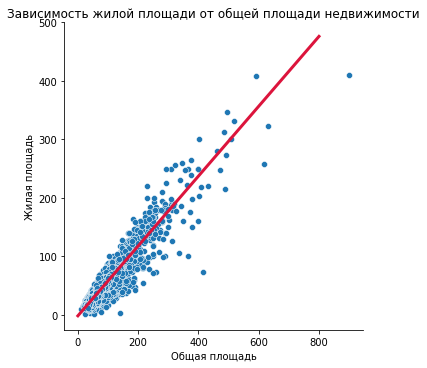

In [ ]:
from scipy.optimize import minimize

# сначала очистим данные от пропущенных значений
living_area_notna = df[df['living_area'].notna()].reset_index(drop=True)

# зададим квадратичную функцию ошибки, зависящую от вектора параметров
def error_function(w):
    sum = 0
    for i in range(len(living_area_notna)):
        sum += (living_area_notna.loc[i, 'living_area'] - (w[0] + w[1] * living_area_notna.loc[i, 'total_area'])) ** 2
    return sum

# решим задачу минимизации заданной функции с некоторым начальным приближением
result = minimize(error_function, np.array([0, 0]))

# зададим линейную функцию, отображающую наше решение
def linear_function(w0, w1, x):
    return (w0 + w1 * x)

# Изобразим решение на графике
sns.relplot(x='total_area', y='living_area', data=df)

total_area = np.linspace(0, 800)
line = plt.plot(total_area, linear_function(result.x[0], result.x[1], total_area), color='crimson', linewidth=3)
plt.title('Зависимость жилой площади от общей площади недвижимости')
plt.xlabel('Общая площадь')
plt.ylabel('Жилая площадь')
plt.show()

In [ ]:
x = df['last_price'] 
y = df['total_area']

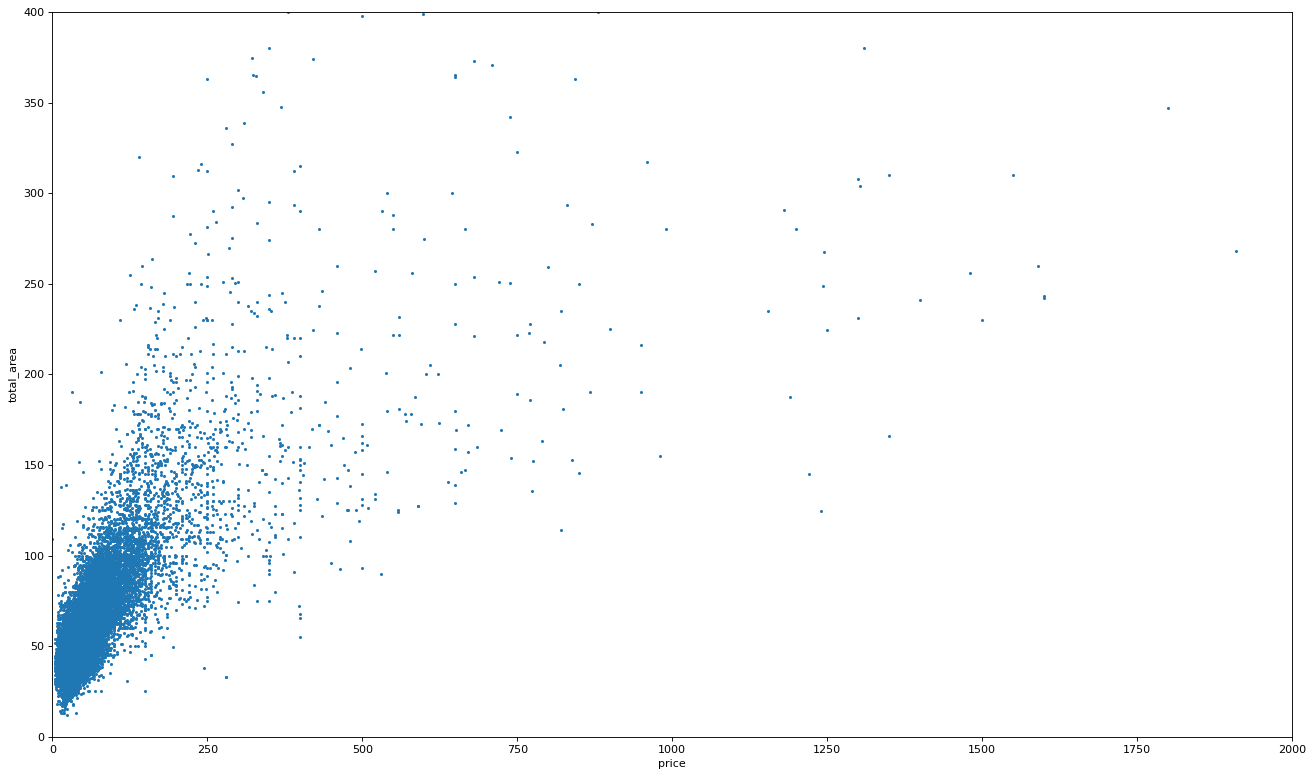

In [ ]:

from matplotlib.pyplot import figure
figure(figsize=(20, 12), dpi=80) # зададим размеры графика

plt.scatter(x / 100000, y, s=3) # построим график (s - размер точек диаграммы)

plt.xlabel('price') # зададим название оси ОХ
plt.ylabel('total_area') # зададим название оси OY

plt.xlim(0, 2000) # зададим границы отображения оси ОХ
plt.ylim(0, 400) # зададим границы отображения оси ОY

plt.show() # выведем график

Где не указано, что квартира является апартаментами, заполняем False, так как вероятнее всего пользователи просто не указали что их квартира - НЕ апартаменты.

In [ ]:
df['is_apartment'] = df['is_apartment'].fillna(0)

Пропуски площади кухни аналогично заполняем средним значением по площадям кухни с аналогичным числом комнат. Можно заметить, что в квартирах с нулём комнат среднее число площади кухни - NaN => можно сделать вывод, что вероятнее всего это квартиры-студии, поэтому заменим их значение на ноль

In [ ]:
mean_kitchen_area = df.groupby(['rooms'])['kitchen_area'].mean()
for i in mean_kitchen_area.index:
  df.loc[(df['kitchen_area'].isna()) & (df['rooms'] == i), 'kitchen_area'] = df.loc[(df['kitchen_area'].isna()) & (df['rooms'] == i), 'kitchen_area'].fillna(round(mean_kitchen_area[i],2))
df['kitchen_area'] = df['kitchen_area'].fillna(0)

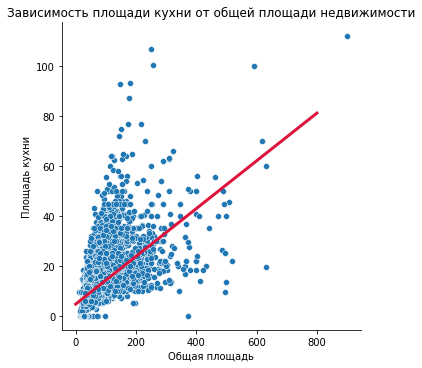

In [ ]:
kitchen_area_notna = df[df['kitchen_area'].notna()].reset_index(drop=True)

# зададим квадратичную функцию ошибки, зависящую от вектора параметров
def error_function(w):
    sum = 0
    for i in range(len(kitchen_area_notna)):
        sum += (kitchen_area_notna.loc[i, 'kitchen_area'] - (w[0] + w[1] * kitchen_area_notna.loc[i, 'total_area'])) ** 2
    return sum

# решим задачу минимизации заданной функции с некоторым начальным приближением
result = minimize(error_function, np.array([0, 0]))

# Изобразим решение на графике
sns.relplot(x='total_area', y='kitchen_area', data=df)

total_area = np.linspace(0, 800)
line = plt.plot(total_area, linear_function(result.x[0], result.x[1], total_area), color='crimson', linewidth=3)
plt.title('Зависимость площади кухни от общей площади недвижимости')
plt.xlabel('Общая площадь')
plt.ylabel('Площадь кухни')
plt.show()

Где не указано, что есть балкон, заполняем 0, так как вероятнее всего пользователи просто не указали что их квартира - БЕЗ балкона.

In [ ]:
df[df['days_exposition'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,0,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,2.76,24.0,NaN,22,0,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
44,13,5350000.0,40.00,2018-11-18T00:00:00,1,2.72,22.0,NaN,3,0,...,9.55,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
45,17,5200000.0,50.60,2018-12-02T00:00:00,2,2.65,9.0,30.3,7,0,...,7.00,NaN,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN
46,17,6600000.0,52.10,2019-01-31T00:00:00,2,2.60,24.0,29.7,9,0,...,8.30,2.0,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,20,21400000.0,145.00,2018-11-02T00:00:00,4,3.00,26.0,71.4,17,0,...,15.60,NaN,Санкт-Петербург,11827.0,11459.0,0.0,NaN,0.0,NaN,NaN
23685,15,2490000.0,31.00,2019-01-24T00:00:00,1,2.50,5.0,17.3,5,0,...,5.60,1.0,Ломоносов,48393.0,51818.0,0.0,NaN,0.0,NaN,NaN
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,0,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.76,3.0,29.7,1,0,...,9.97,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['balcony'].value_counts()

1.0    4195
0.0    3713
2.0    3657
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

In [ ]:
df['balcony'] = df['balcony'].fillna(0)

Пропуски данных с названием населённого пункта никак логично не предобработать, поэтому удалим их в силу отсутствия статистической значимости (их всего 0.4% от общего числа)

In [ ]:
df.dropna(subset=['locality_name'], inplace=True)

Пропуски в следующих полях обработать не является возможным из сообрежений логики:
*   airports_nearest
*   cityCenters_nearest
*   parks_around3000
*   parks_nearest
*   ponds_around3000
*   ponds_nearest
*   days_exposition

Таким образом постфактум анализа исходного сета было принято решение о замене пропусков в следующих полях:


*   ceiling_height
*   living_area
*   floors_total
*   is_apartment
*   balcony
*   kitchen_area
*   locality_name

В остальных полях обрабатывать пропуски либо нет необходимости , либо не предоставляется возожным, так как нет подходящей по смыслу замены.

Причинами наличия пропусков может быть следующее:


1.   Пользователи пропускают заполнение поля, если оно к ним не имеет отношения (например, пропуски в полях апартаменты или же балконы);
2.   Пользователи за незнанием/большой отдалённостью или же вообще отсутствием не указывают такие данные как расстояние до аэропорта/парка/водоёма, что также приводит к пропускам.

## Анализ типа данных


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21700 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Поле first_day_exposition логично преобразовать к типу данных datetime

In [ ]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])

Заменим количество этажей на целое число, так как общее количество этажей не может измеряться в долях чего-либо



In [ ]:
df['floors_total'] = df['floors_total'].astype('int')

Тип данных у поля is_apartment лучше поменять на bool, так как там либо Да, либо Нет

In [ ]:
df['is_apartment'] = df['is_apartment'].astype('bool')

Число балконов также не может быть не целым числом, поэтому заменим его на целое

In [ ]:
df['balcony'] = df['balcony'].astype('int')

## Устранение неявных дубликатов

Сначала изучим значения названия населённых пунктов

In [ ]:
a = df['locality_name'].value_counts()
list(a.index)

['Санкт-Петербург',
 'посёлок Мурино',
 'посёлок Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'посёлок Парголово',
 'Гатчина',
 'деревня Кудрово',
 'Выборг',
 'Петергоф',
 'Сестрорецк',
 'Красное Село',
 'Кудрово',
 'деревня Новое Девяткино',
 'Сертолово',
 'Ломоносов',
 'Кириши',
 'Сланцы',
 'Волхов',
 'Кингисепп',
 'Тосно',
 'Кронштадт',
 'Никольское',
 'Коммунар',
 'Сосновый Бор',
 'Кировск',
 'Отрадное',
 'посёлок Бугры',
 'Приозерск',
 'посёлок Металлострой',
 'деревня Старая',
 'городской посёлок Янино-1',
 'Шлиссельбург',
 'Луга',
 'Тихвин',
 'поселок Бугры',
 'посёлок Стрельна',
 'посёлок Тельмана',
 'Павловск',
 'поселок Романовка',
 'Волосово',
 'Мурино',
 'поселок Мурино',
 'посёлок городского типа Сиверский',
 'Ивангород',
 'городской посёлок Новоселье',
 'городской посёлок Мга',
 'поселок городского типа имени Свердлова',
 'Сясьстрой',
 'Зеленогорск',
 'посёлок Щеглово',
 'посёлок городского типа Кузьмоловский',
 'поселок городского типа Синявино',
 'посёлок Новогорелов

Заметим, что Мурино встречается в трёх вариациях, поэтому заменим на "Мурино" все возможные варианты

In [ ]:
df.loc[df['locality_name'].str.contains('Мурино'), 'locality_name'] = 'Мурино'

Аналогично Кудрово

In [ ]:
df.loc[df['locality_name'].str.contains('Кудрово'), 'locality_name'] = 'Кудрово'

Также обработали значения поселок/посёлок Бугры

In [ ]:
df.loc[df['locality_name'].str.contains('Бугры'), 'locality_name'] = 'посёлок Бугры'

Аналогичным образом для остальных

In [ ]:
df.loc[df['locality_name'].str.contains('Тельмана'), 'locality_name'] = 'Тельмана'
df.loc[df['locality_name'].str.contains('Свердлова'), 'locality_name'] = 'посёлок городского типа Свердлова'
df.loc[df['locality_name'].str.contains('Щеглово'), 'locality_name'] = 'Щеглово'
df.loc[df['locality_name'].str.contains('Кузьмоловский'), 'locality_name'] = 'посёлок городского типа Кузьмоловский'
df.loc[df['locality_name'].str.contains('Рощино'), 'locality_name'] = 'посёлок городского типа Рощино'
df.loc[df['locality_name'].str.contains('Новый Свет'), 'locality_name'] = 'посёлок Новый Свет'
df.loc[df['locality_name'].str.contains('Большая Ижора'), 'locality_name'] = 'посёлок городского типа Большая Ижора'
df.loc[df['locality_name'].str.contains('Токсово'), 'locality_name'] = 'посёлок городского типа Токсово'
df.loc[df['locality_name'].str.contains('Гарболово'), 'locality_name'] = 'посёлок Гарболово'
df.loc[df['locality_name'].str.contains('Кобралово'), 'locality_name'] = 'посёлок Кобралово'
df.loc[df['locality_name'].str.contains('Мга'), 'locality_name'] = 'посёлок городского типа Мга'
df.loc[df['locality_name'].str.contains('Назия'), 'locality_name'] = 'посёлок городского типа Назия'
df.loc[df['locality_name'].str.contains('Кузьмоловский'), 'locality_name'] = 'посёлок городского типа Кузьмоловский'
df.loc[df['locality_name'].str.contains('Вырица'), 'locality_name'] = 'посёлок городского типа Вырица'
df.loc[df['locality_name'].str.contains('Павлово'), 'locality_name'] = 'посёлок городского типа Павлово'
df.loc[df['locality_name'].str.contains('Советский'), 'locality_name'] = 'посёлок городского типа Советский'
df.loc[df['locality_name'].str.contains('Приладожский'), 'locality_name'] = 'посёлок городского типа Приладожский'
df.loc[df['locality_name'].str.contains('Любань'), 'locality_name'] = 'посёлок Любань'
df.loc[df['locality_name'].str.contains('Фёдоровское'), 'locality_name'] = 'деревня Фёлоровское'
df.loc[df['locality_name'].str.contains('Янино-1'), 'locality_name'] = 'городской посёлок Янино-1'
df.loc[df['locality_name'].str.contains('Калитино'), 'locality_name'] = 'деревня Калитино'
df.loc[df['locality_name'].str.contains('Ильичёво'), 'locality_name'] = 'посёлок Ильичёво'
df.loc[df['locality_name'].str.contains('Мичуринское'), 'locality_name'] = 'посёлок Мичуринское'
df.loc[df['locality_name'].str.contains('Красный Бор'), 'locality_name'] = 'посёлок городского типа Красный Бор'
df.loc[df['locality_name'].str.contains('Кобралово'), 'locality_name'] = 'посёлок Кобралово'
df.loc[df['locality_name'].str.contains('Аннино'), 'locality_name'] = 'посёлок Аннино'
df.loc[df['locality_name'].str.contains('Стеклянный'), 'locality_name'] = 'посёлок Стеклянный'
df.loc[df['locality_name'].str.contains('Лебяжье'), 'locality_name'] = 'посёлок городского типа Лебяжье'
df.loc[df['locality_name'].str.contains('Усть-Луга'), 'locality_name'] = 'посёлок Усть-Луга'
df.loc[df['locality_name'].str.contains('Терволово'), 'locality_name'] = 'посёлок Терволово'
df.loc[df['locality_name'].str.contains('Форносово'), 'locality_name'] = 'посёлок городского типа Форносово'
df.loc[df['locality_name'].str.contains('Поляны'), 'locality_name'] = 'посёлок Поляны'
df.loc[df['locality_name'].str.contains('Гаврилово'), 'locality_name'] = 'посёлок Гаврилово'
df.loc[df['locality_name'].str.contains('Вещево'), 'locality_name'] = 'посёлок станции Вещево'
df.loc[df['locality_name'].str.contains('Петровское'), 'locality_name'] = 'посёлок Петровское'
df.loc[df['locality_name'].str.contains('Громово'), 'locality_name'] = 'посёлок Громово'
df.loc[df['locality_name'].str.contains('Перово'), 'locality_name'] = 'посёлок Перово'
df.loc[df['locality_name'].str.contains('Победа'), 'locality_name'] = 'посёлок Победа'
df.loc[df['locality_name'].str.contains('Лесогорский'), 'locality_name'] = 'посёлок городского типа Лесогорский'
df.loc[df['locality_name'].str.contains('Мельниково'), 'locality_name'] = 'посёлок Мельниково'
df.loc[df['locality_name'].str.contains('Зимитицы'), 'locality_name'] = 'посёлок Зимитицы'
df.loc[df['locality_name'].str.contains('Свирь'), 'locality_name'] = 'посёлок Свирь'
df.loc[df['locality_name'].str.contains('Лесное'), 'locality_name'] = 'посёлок Лесное'
df.loc[df['locality_name'].str.contains('Лисий Нос'), 'locality_name'] = 'посёлок Лисий Нос'
df.loc[df['locality_name'].str.contains('Жилгородок'), 'locality_name'] = 'посёлок Жилгородок'
df.loc[df['locality_name'].str.contains('Рабитицы'), 'locality_name'] = 'посёлок Рабитицы'
df.loc[df['locality_name'].str.contains('Возрождение'), 'locality_name'] = 'посёлок Возрождение'
df.loc[df['locality_name'].str.contains('Приветнинское'), 'locality_name'] = 'посёлок станции Приветнинское'
df.loc[df['locality_name'].str.contains('Старая Малукса'), 'locality_name'] = 'посёлок Старая Малукса'
df.loc[df['locality_name'].str.contains('Рябово'), 'locality_name'] = 'посёлок Рябово'
df.loc[df['locality_name'].str.contains('Пансионат Зелёный Бор'), 'locality_name'] = 'посёлок Пансионат Зелёный Бор'
df.loc[df['locality_name'].str.contains('Коробицыно'), 'locality_name'] = 'посёлок Коробицыно'
df.loc[df['locality_name'].str.contains('Сумино'), 'locality_name'] = 'посёлок Сумино'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony         

## Обработка аномальных значений

In [ ]:
df['last_price'].value_counts().sort_index()

12190.0        1
430000.0       2
440000.0       1
450000.0       4
470000.0       3
              ..
300000000.0    1
330000000.0    1
401300000.0    1
420000000.0    1
763000000.0    1
Name: last_price, Length: 2925, dtype: int64

Так как стоимость квартир в деревнях оценить тяжело, то рассмотрим аномальные значения стоимости в городе Санкт-Петербург

In [ ]:
df.loc[df['locality_name'] == 'Санкт-Петербург', 'last_price'].value_counts().sort_index()

12190.0        1
1190000.0      1
1200000.0      1
1350000.0      1
1400000.0      1
              ..
300000000.0    1
330000000.0    1
401300000.0    1
420000000.0    1
763000000.0    1
Name: last_price, Length: 2358, dtype: int64

Наблюдаем, что есть квартира площадью 109 квадратных метров в городе Санкт-Петербург за 12 тысяч, вероятнее всего человек ошибся тремя нулями

In [ ]:
df.loc[df['last_price'] == 12190, 'last_price'] = 12190000

Теперь уберём все квартиры выше 11.9 миллионов, так как они сильно выбиваются из статистики

In [ ]:
df = df.loc[df['last_price'] <= 11900000]

Также уберём все квартиры дешевле 700000

In [ ]:
df = df.loc[df['last_price'] >= 700000]

In [ ]:
df['ceiling_height'].value_counts().sort_index()

1.00      1
1.20      1
1.75      1
2.00     10
2.20      1
         ..
25.00     7
26.00     1
27.00     8
27.50     1
32.00     2
Name: ceiling_height, Length: 161, dtype: int64

Уберём значения меньше 2.25 метров

In [ ]:
df = df.loc[df['ceiling_height'] >= 2.25]

Уберём квартиру со стометровыми потолками

In [ ]:
df = df[df['ceiling_height'] != 100]

Все значения больше 20 разделим на 10

In [ ]:
df.loc[df['ceiling_height'] >= 20, 'ceiling_height'] = df.loc[df['ceiling_height'] >= 20, 'ceiling_height']/10

Теперь уберём все квартиры c потолками выше 3.05 метров

In [ ]:
df = df.loc[df['ceiling_height'] <= 3.05]

In [ ]:
df['rooms'].value_counts()

1    7791
2    7229
3    4644
4     652
0      74
5      50
6       7
Name: rooms, dtype: int64

Уберём редкие значения в виде числа комнат выше чем 6

In [ ]:
df = df.loc[df['rooms'] <= 6]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20447 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20447 non-null  int64         
 1   last_price            20447 non-null  float64       
 2   total_area            20447 non-null  float64       
 3   first_day_exposition  20447 non-null  datetime64[ns]
 4   rooms                 20447 non-null  int64         
 5   ceiling_height        20447 non-null  float64       
 6   floors_total          20447 non-null  int64         
 7   living_area           18857 non-null  float64       
 8   floor                 20447 non-null  int64         
 9   is_apartment          20447 non-null  bool          
 10  studio                20447 non-null  bool          
 11  open_plan             20447 non-null  bool          
 12  kitchen_area          20447 non-null  float64       
 13  balcony         

In [ ]:
df['month'] = df['first_day_exposition'].dt.month

In [ ]:
df['month']

1        12
2         8
4         6
5         9
6        11
         ..
23693     8
23695     1
23696     2
23697     3
23698     7
Name: month, Length: 20447, dtype: int64

In [ ]:
df['day'] = df['first_day_exposition'].dt.weekday
df['year'] = df['first_day_exposition'].dt.year

In [ ]:
df['cost_per_meter'] = df['last_price']/df['total_area']

In [ ]:
df['cost_per_meter']

1         82920.792079
2         92785.714286
4        100000.000000
5         95065.789474
6         99195.710456
             ...      
23693     73717.948718
23695     52542.372881
23696     44091.710758
23697    149511.400651
23698     41795.665635
Name: cost_per_meter, Length: 20447, dtype: float64

#Проверка гипотез

Оценим зависимость стоимости квартиры от площади/расстояния до центра города

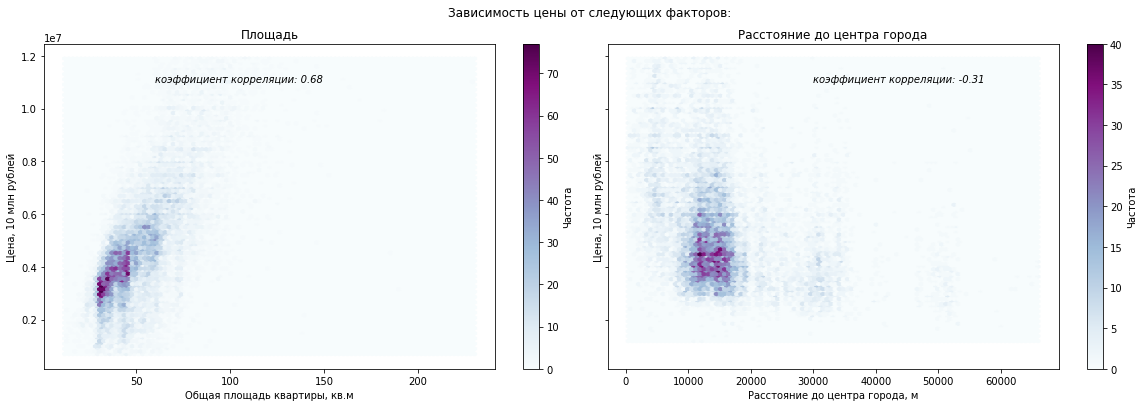

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(17, 6), gridspec_kw={'wspace': 0})
fig.suptitle('Зависимость цены от следующих факторов:')

ax1.set_title('Площадь')
ax1.set_ylabel('Цена, 10 млн рублей')
ax1.set_xlabel('Общая площадь квартиры, кв.м')
ax1.text(60, 11000000, 
         'коэффициент корреляции: ' + str(round(df['last_price'].corr(df['total_area']), 2)), 
         style='italic')
hb1 = ax1.hexbin(df['total_area'], df['last_price'], cmap='BuPu')
cb1 = fig.colorbar(hb1, ax=ax1)
cb1.set_label('Частота')

ax2.set_title('Расстояние до центра города')
ax2.set_ylabel('Цена, 10 млн рублей')
ax2.set_xlabel('Расстояние до центра города, м')
ax2.text(30000, 11000000, 
         'коэффициент корреляции: ' + str(round(df['last_price'].corr(df['cityCenters_nearest']), 2)), 
         style='italic')
hb2 = ax2.hexbin(df['cityCenters_nearest'], df['last_price'], cmap='BuPu')
cb2 = fig.colorbar(hb2, ax=ax2)
cb2.set_label('Частота')

plt.tight_layout(pad=3)
plt.show()

Определим зависимость стоимости квартир от расстояния от центра

In [ ]:
def categorize_centre(row):
  if row['cityCenters_nearest'] <= 2000:
    return 1
  elif 2001 <= row['cityCenters_nearest'] <= 4500:
    return 2
  elif 4501 <= row['cityCenters_nearest'] <= 8000:
    return 3
  elif 8001 <= row['cityCenters_nearest'] <= 10000:
    return 4
  elif 10001 <= row['cityCenters_nearest'] <= 15000:
    return 5
  elif row['cityCenters_nearest'] > 15000:
    return 6

In [ ]:
df['cat_centre'] = df.apply(categorize_centre, axis=1)

In [ ]:
df2 = df.dropna(subset=['cat_centre', 'cat_floor'])

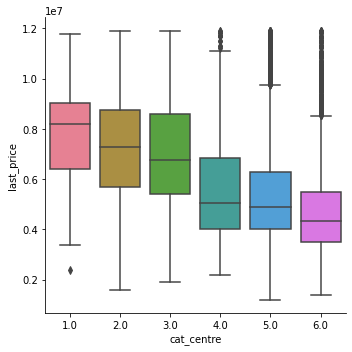

In [ ]:
sns.catplot(x='cat_centre', y="last_price", kind="box", data=df, palette='husl')

Проверяем гипотезу, что квартиры с большим числом комнат стоят дороже

Построим график зависимости стоимости квартиры от числа комнат.



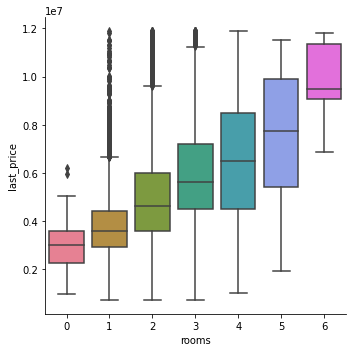

In [ ]:
sns.catplot(x='rooms', y="last_price", kind="box", data=df, palette='husl')

Для оценки зависимости рыночной стоимости жилья от его площади напишем функцию, разбивающую жильё на категории

In [ ]:
def categorize_area(row):
  if row['living_area'] <= 30:
    return 'A'
  elif 31 <= row['living_area'] <= 50:
    return 'B'
  elif 51 <= row['living_area'] <= 75:
    return 'C'
  elif row['living_area'] > 75:
    return 'D'

Применим функцию к исходному датасету

In [ ]:
df['cat_area'] = df.apply(categorize_area, axis=1)

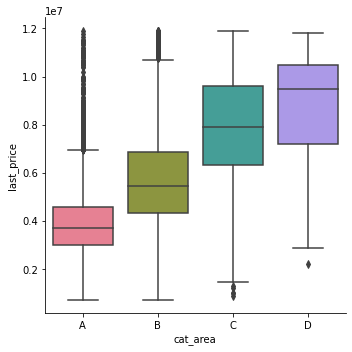

In [ ]:
sns.catplot(x='cat_area', y="last_price", kind="box", data=df, palette='husl')

Заметим, что отсутствует зависимость между любыми показателями даты от конечной стоимости жилья

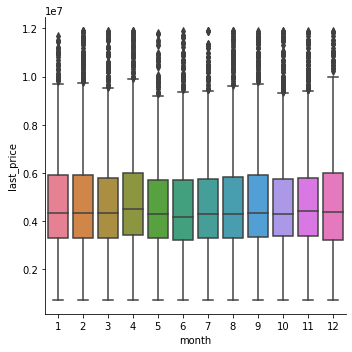

In [ ]:
sns.catplot(x='month', y="last_price", kind="box", data=df, palette='husl')

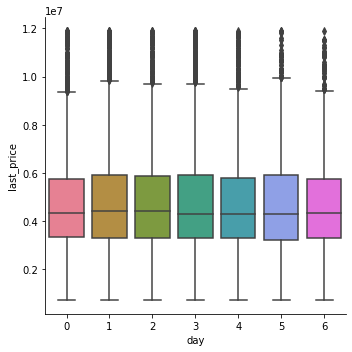

In [ ]:
sns.catplot(x='day', y="last_price", kind="box", data=df, palette='husl')

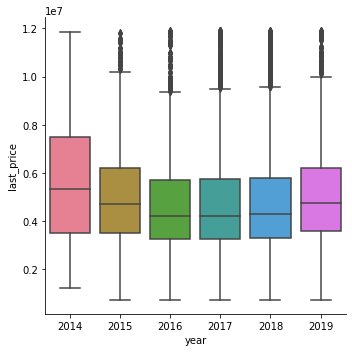

In [ ]:
sns.catplot(x='year', y="last_price", kind="box", data=df, palette='husl')

Также явным образом можно оценить, что наличие балкона не является влияющим факторм на конечную стоимость квартиры

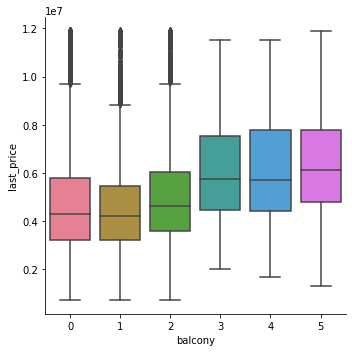

In [ ]:
sns.catplot(x='balcony', y="last_price", kind="box", data=df, palette='husl')

Разобьём квартиры по признаку высоты этажа относительно общего числа этажей

In [ ]:
df['floor_percent'] = (df['floor'] / df['floors_total']) * 100

In [ ]:
def categorize_floor(row):
  if row['floor'] == 1:
    return 1
  elif row['floor_percent'] <= 25:
    return 2
  elif 26 < row['floor_percent'] <= 50:
    return 3
  elif 51 < row['floor_percent'] <= 75:
    return 4
  elif 76 < row['floor_percent'] <= 99:
    return 5
  elif row['floor_percent'] == 100:
    return 6

In [ ]:
df['cat_floor'] = df.apply(categorize_floor, axis=1)

Первый и последний этажи категории 1 и 6 соответственно

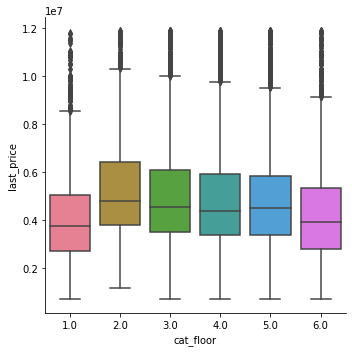

In [ ]:
sns.catplot(x='cat_floor', y="last_price", kind="box", data=df, palette='husl')

# Моделирование


In [ ]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'month', 'day', 'year',
       'cost_per_meter', 'cat_centre', 'cat_area', 'floor_percent',
       'cat_floor'],
      dtype='object')

Зададим признаки по общей площади и числу комнат

In [ ]:
X, y = df[['total_area']], df['rooms'] # задаем признаки (поле total_area) и объекты (поле rooms)

Импортируем модуль для разделения выборки на данные для обучения и тестирования

In [ ]:
from sklearn.model_selection import train_test_split

Разделяем выборку на данные для обучения (80%) и тестирования (20%)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

При помощи модуля LogisticRegression создадим модель и обучим её

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

Далее оценим качество модели

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, model.predict(X_train)) 

0.7106437610808828

In [ ]:
accuracy_score(y_test, model.predict(X_test)) 

0.7080684596577017

In [ ]:
from sklearn.linear_model import LinearRegression

Обучим модель, способную определять стоимость квартиры по её отдалённости от центра города, этажности, числу комнат и общей площади

In [ ]:
X_df = df2[['cat_centre', 'cat_floor', 'rooms', 'total_area']]
y_df = df2['last_price']
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size = 0.2)
model_df = LinearRegression()
model_df.fit(X_train_df, y_train_df)
y_pred_df = model_df.predict(X_test_df) 

Сформируем pandas dataframe, в который добавим тестовые данные, по которым будет предсказана примерная рыночная стоимость жилья

In [ ]:
d = {'cat_centre': [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6], 
     'cat_floor': [1, 6, 3, 5, 1, 6, 2, 4, 3, 2, 5, 1], 
     'rooms': [2, 2, 4, 1, 2, 2, 3, 2, 1, 2, 4, 2], 
     'total_area': [50, 64, 92, 31, 46, 42, 58, 50, 29, 44, 100, 40]}
check_model = pd.DataFrame(data=d)
X_df_price = check_model[['cat_centre', 'cat_floor', 'rooms', 'total_area']]
check_model['last_price'] = model_df.predict(X_df_price)

In [ ]:
check_model['last_price'] = check_model['last_price'].astype(int)

In [ ]:
check_model

,cat_centre,cat_floor,rooms,total_area,last_price
0,1,1,2,50,6601839
1,1,6,2,64,8194039
2,2,3,4,92,9346651
3,2,5,1,31,4945801
4,3,1,2,46,5339186
5,3,6,2,42,5073702
6,4,2,3,58,5570292
7,4,4,2,50,5415489
8,5,3,1,29,3405707
9,5,2,2,44,4312410


**В результате проведённого исследования была сформирована модель, позволяющая по её первичным признакам определить то, какова будет её рыночная стоимость. Данная модель позволяет автоматизировать процесс формирования рыночной стоимости недвижимости, а также выявлять наиболее недооценённое жилье на рынке.**